In [1]:
#!g1.1
%pip install gensim

In [2]:
#!g1.1
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [3]:
#!g1.1
import gensim.downloader as api


fasttext = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [4]:
#!g1.1
import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []

        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [5]:
#!g1.1
from torch.utils.data import Dataset


class IMDB(Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path)

        texts = self.df['review'].values

        self.vocab = Vocabulary(texts, min_freq=5)

        self.label2idx = {'positive': 0, 'negative': 1}

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

In [6]:
dataset = IMDB('IMDB Dataset.csv')

In [7]:
#!g1.1
from torch.utils.data import random_split


train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [8]:
#!g1.1
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])

    return texts, labels

In [9]:
#!g1.1
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [187]:
#!g1.1
# https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
import torch.nn.functional as F
import torch.nn as nn


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        hidden_channels = 32
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, hidden_channels, kernel_size=(3, embedding_dim), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        self.identity_conv = nn.Conv2d(hidden_channels * 4, hidden_channels * 4, kernel_size=(1, 1))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1152, 1),  # Исправленный размер выхода
        )

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # Шаг 1: Применение эмбеддинга
        x = self.embedding(x)  # x.shape = [batch_size, seq_len, embedding_dim]

        # Шаг 2: Добавление дополнительного измерения для свертки
        x = x.unsqueeze(1)  # x.shape = [batch_size, 1, seq_len, embedding_dim]

        x = [(self.conv_layers(x)).squeeze(3) for conv in self.conv_layers]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        # Шаг 6: Проход через полносвязный слой для бинарной классификации
        x = self.fc(x)  # x.shape = [batch_size, 1]

        return x

In [188]:
#!g1.1
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [189]:
vectors = dataset.vocab.build_vectors(fasttext)

In [190]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [191]:
#!g1.1
from tqdm import tqdm


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model) -> float:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [192]:
#!g1.1
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [193]:
#!g1.1
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [194]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        # Обучение модели
        train_loss, train_accuracy = train(model)
        # Оценка модели
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        # Перемещаем тензоры на CPU и преобразуем в числа
        train_loss_history.append(train_loss)  # .item() для скалярных тензоров
        valid_loss_history.append(valid_loss)
        train_accuracy_history.append(train_accuracy.cpu())  # .cpu() для перемещения на CPU, затем .item()
        valid_accuracy_history.append(valid_accuracy.cpu())

        # Очищаем вывод и рисуем графики
        clear_output(wait=True)
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [195]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

In [196]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cuda:0
Tesla T4


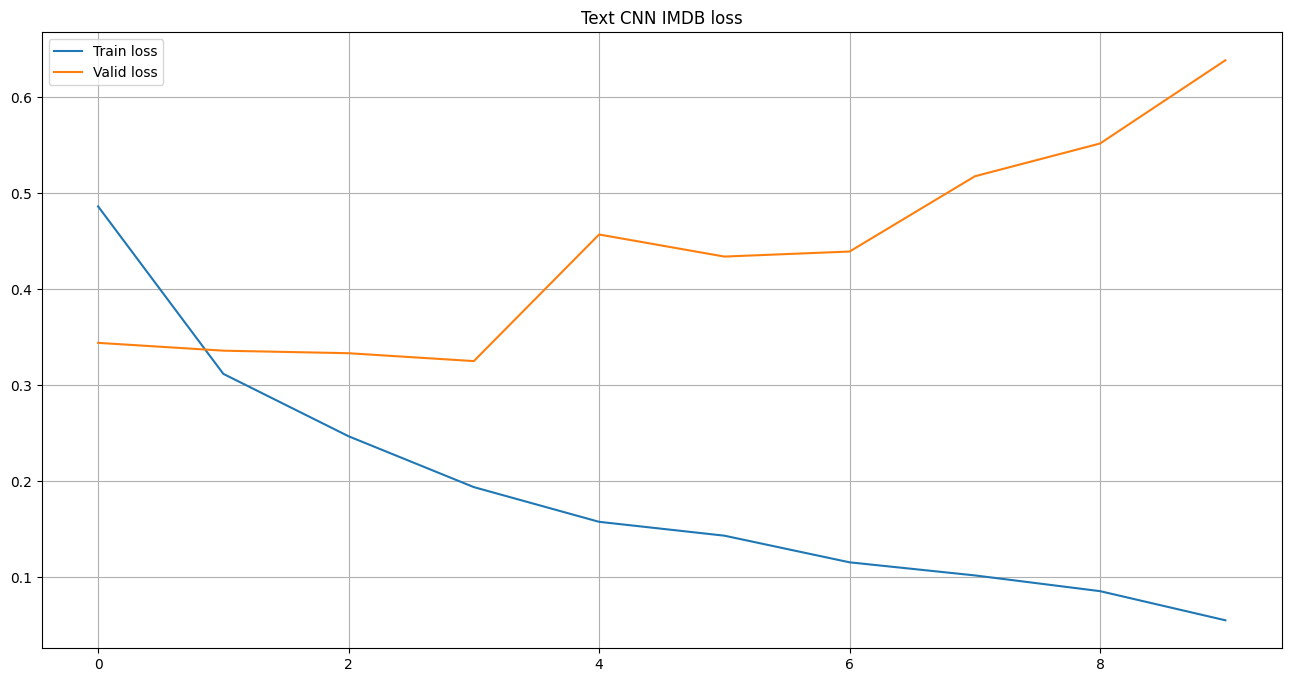

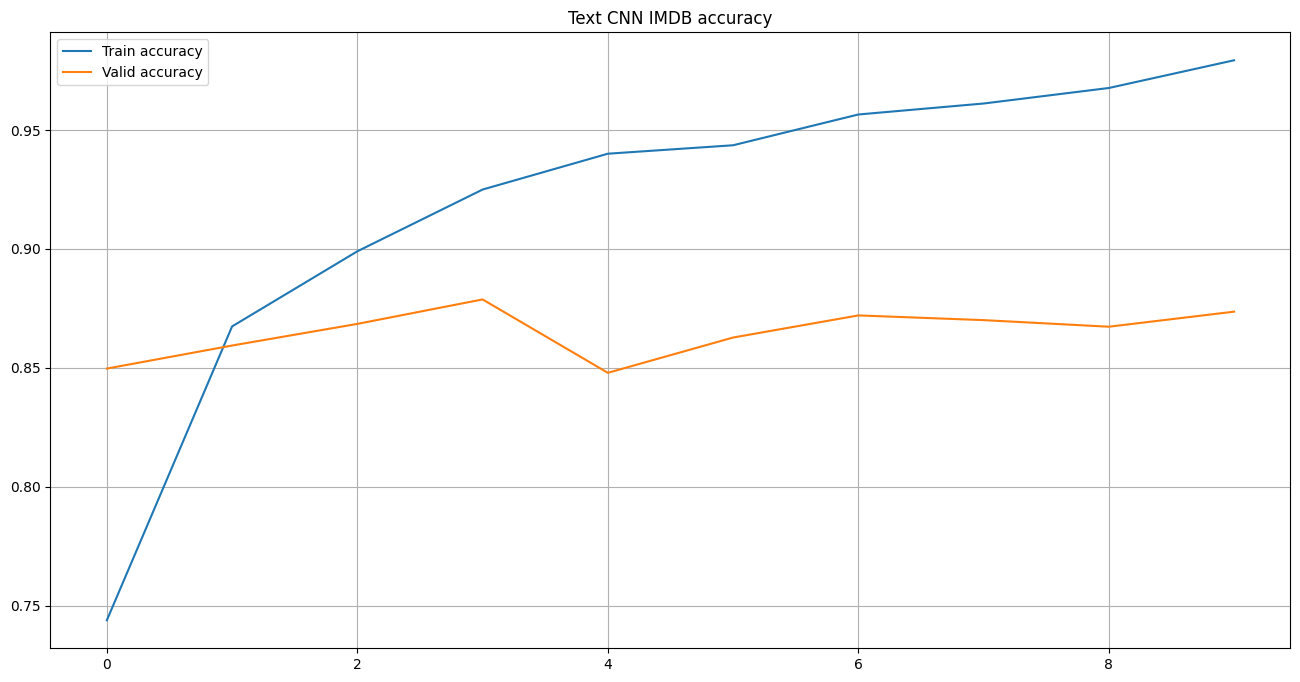

In [197]:
#!g1.1
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'Text CNN IMDB')